# Black-Litterman Model

In [1]:
from numpy import matrix, array, zeros, empty, sqrt, ones, dot, append, mean, cov, transpose, linspace
from numpy.linalg import inv, pinv
from pylab import *
#from structures.quote import QuoteSeries
import scipy.optimize
import random
import pandas as pd
# import pandas_datareader.data as web

In [2]:
def loadData(name):
    df = pd.read_excel('RRF Asset Allocation Subsector Historical Prices.xlsx',sheet_name=name,skiprows=6)
    single_df=df['PX_LAST'].pct_change(-1)
    single_df[np.isnan(single_df)] = 0
    # single_df = df.iloc[:,:1]
    return single_df.to_xarray()

names       - array of assets' names 
<br>
prices      - array of historical (daily) prices
<br>
caps        - array of assets' market capitalizations
<br>
weights     - array of assets' weights (derived from mkt caps)
<br>
expreturns  - expected returns based on historical data
<br>
covars      - covariance matrix between assets based on historical data
<br>
rf          - risk free rate
<br>
lmb         - lambda - risk aversion coefficient
<br>
C           - assets covariance matrix
<br>
V           - assets variances (diagonal in covariance matrix)
<br>
W           - assets weights
<br>
R           - assets returns
<br>
mean        - portfolio historical return
<br>
var         - portfolio historical variance
<br>
Pi          - portfolio equilibrium excess returns
<br>
tau         - scaling factor for Black-litterman


In [3]:
def assets_meanvar(daily_return, caps):
    returns = np.matrix(daily_return)                         # create numpy matrix from prices
    weights = array(caps) / sum(caps)       # create weights

    # create matrix of historical returns
    rows, cols = returns.shape

    # calculate expected returns
    expreturns = array([])
    for r in range(rows):
            expreturns = append(expreturns, mean(returns[r]))
    # calculate covariances
    covars = cov(returns)

    expreturns = (1+expreturns)**250-1      # Annualize expected returns
    covars = covars * 250                           # Annualize covariances

    return weights, expreturns, covars

In [4]:
# Calculates portfolio mean return
def port_mean(W, R):
        return sum(R*W)

# Calculates portfolio variance of returns
def port_var(W, C):
        return dot(dot(W, C), W)

# Combination of the two functions above - mean and variance of returns calculation
def port_mean_var(W, R, C):
        return port_mean(W, R), port_var(W, C)

In [5]:
def print_assets(names, W, R, C):
        print("%-25s %6s %6s %6s %s" % ("Name", "Weight", "Return", "Dev", "   Correlations"))
        for i in range(len(names)):
                print("%-25s %5.1f%% %5.1f%% %5.1f%%    " % (names[i], 100*W[i], 100*R[i], 100*C[i,i]**.5), end='')
                for j in range(i+1):
                        corr = C[i,j] / (sqrt(C[i,i]) * (sqrt(C[j,j]))) # calculate correlation from covariance
                        print("%.3f " % corr, end='')
                print()

### Run the functions~

In [6]:
# names = ['textiles_LuxGoods','pharm_biot','fin_services','machinery','industrial_engineering','utilities','metal_mining','media','software']
# sheetnames = ['MSCI EU TEX,APP,LUXG','FTSE350 PHARM&BIOT','FTSE350 FIN SERVICES','S&P500 MACHINERY','FTSE350 IND ENG','FTSE350 UTILITIES','FTSE350 METALS & MINING','FTSE350 MEDIA','FTSE350 SOFTWARE']

#               'pharm_biot':['FTSE350 PHARM&BIOT',194853.10],

# 'metal_mining':['FTSE350 METALS & MINING',18920.00]
sub_sectors = {'textiles_LuxGoods':['MSCI EU TEX,APP,LUXG', 35416.59],
               'pharm_biot':['FTSE350 PHARM&BIOT',194853.10],
               'fin_services':['FTSE350 FIN SERVICES',91107.25],
               'industrial_engineering':['FTSE350 IND ENG',18920.00],
               'utilities':['FTSE350 UTILITIES',57695.11],
               'software':['FTSE350 SOFTWARE',48880.44],
               'RE_industrial':['FTSENAREIT INDUSTRIAL', 67531.86 ]}
names = []
prices = []
caps = []
for sector_name,values in sub_sectors.items():
    names.append(sector_name)
    data = loadData(values[0])[:365]
    prices.append(data)
    caps.append(values[1])

# Estimate assets's expected return and covariances
W, R, C = assets_meanvar(prices, caps)
print(W)
# Calculate portfolio historical return and variance
mean, var = port_mean_var(W, R, C)
print(mean)
print(var)

[0.06884971 0.37879365 0.17711213 0.0367804  0.11215906 0.09502338
 0.13128167]
0.14849934477298496
0.009832097892708813


In [7]:
rf = .015    

In [8]:
print("Historical Weights")
print_assets(names, W, R, C)

Historical Weights
Name                      Weight Return    Dev    Correlations
textiles_LuxGoods           6.9%  12.0%  20.1%    1.000 
pharm_biot                 37.9%  17.1%  16.4%    0.061 1.000 
fin_services               17.7%  13.5%  19.3%    0.126 0.341 1.000 
industrial_engineering      3.7%   4.3%  23.2%    0.113 0.277 0.734 1.000 
utilities                  11.2%   5.9%  20.4%    0.082 0.013 -0.022 0.001 1.000 
software                    9.5%  18.2%  22.7%    0.075 0.045 -0.008 -0.001 0.351 1.000 
RE_industrial              13.1%  19.8%  17.1%    0.015 -0.021 -0.041 -0.052 0.159 0.059 1.000 


### Run different optimisation models

In [9]:
# Mean-Variance Optimization (based on historical returns)
# optimize_and_display('Optimization based on Historical returns', names, R, C, rf, color='red')
# show()

# Black-litterman reverse optimization
lmb = (mean - rf) / var                         # Calculate return/risk trade-off
Pi = dot(dot(lmb, C), W)                        # Calculate equilibrium excess returns

# Mean-variance Optimization (based on equilibrium returns)
# optimize_and_display('Optimization based on Equilibrium returns', names, Pi+rf, C, rf, color='green')
# show()

###### Determine View matrix

In [10]:
# Determine views (Q) and link (P) matrices
# Neutral
Q1 =np.array([-0.05,0.06,0.0,0.0,0.03,0.04,0.05]) 

# worse case
Q2 =np.array([-0.1,0.03,0.,0.,-0.02,-0.07,0.02]) 

# best case
Q3 =np.array([0.03,0.1,0,0.07,0.05,0.15,0.07]) 

# print('Views Matrix')
print(Q1)

[-0.05  0.06  0.    0.    0.03  0.04  0.05]


In [11]:
P = np.identity(Q1.shape[0])
print('Link Matrix')
print(P)

Link Matrix
[[1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1.]]


In [12]:
tau = .025 # scaling factor

###### Calculate Pi

In [13]:
# Calculate omega - uncertainty matrix about views
omega = dot(dot(dot(tau, P), C), transpose(P)) # 0.025 * P * C * transpose(P)
# Calculate equilibrium excess returns with views incorporated
sub_a = inv(dot(tau, C))
sub_b = dot(dot(transpose(P), inv(omega)), P)
sub_c = dot(inv(dot(tau, C)), Pi)
sub_d1 = dot(dot(transpose(P), inv(omega)), Q1)
sub_d2 = dot(dot(transpose(P), inv(omega)), Q2)
sub_d3 = dot(dot(transpose(P), inv(omega)), Q3)
Pi_1 = dot(inv(sub_a + sub_b), (sub_c + sub_d1))
Pi_2 = dot(inv(sub_a + sub_b), (sub_c + sub_d2))
Pi_3 = dot(inv(sub_a + sub_b), (sub_c + sub_d3))
print(Pi_1)
print(Pi_2)
print(Pi_3)

[0.01139484 0.11618416 0.08115927 0.08071154 0.06378159 0.07313987
 0.0534439 ]
[-0.01360516  0.10118416  0.08115927  0.08071154  0.03878159  0.01813987
  0.0384439 ]
[0.05139484 0.13618416 0.08115927 0.11571154 0.07378159 0.12813987
 0.0634439 ]


###### Visualisation

Given risk-free rate, assets returns and covariances, this function calculates mean-variance frontier and returns its [x,y] points in two arrays

In [14]:
def solve_frontier(R, C, rf):
        def fitness(W, R, C, r):
                # For given level of return r, find weights which minimizes
                # portfolio variance.
                mean, var = port_mean_var(W, R, C)
                # Big penalty for not meeting stated portfolio return effectively serves as optimization constraint
                penalty = 50*abs(mean-r)
                return var + penalty
        frontier_mean, frontier_var, frontier_weights = [], [], []
        n = len(R)      # Number of assets in the portfolio
        for r in linspace(min(R), max(R), num=20): # Iterate through the range of returns on Y axis
                W = ones([n])/n         # start optimization with equal weights
                b_ = [(0,1) for i in range(n)]
                c_ = ({'type':'eq', 'fun': lambda W: sum(W)-1. })
                optimized = scipy.optimize.minimize(fitness, W, (R, C, r), method='SLSQP', constraints=c_, bounds=b_)
                if not optimized.success:
                        raise BaseException(optimized.message)
                # add point to the min-var frontier [x,y] = [optimized.x, r]
                frontier_mean.append(r)                                                 # return
                frontier_var.append(port_var(optimized.x, C))   # min-variance based on optimized weights
                frontier_weights.append(optimized.x)
        return array(frontier_mean), array(frontier_var), frontier_weights

Given risk-free rate, assets returns and covariances, this function calculates weights of tangency portfolio with respect to sharpe ratio maximization

In [15]:
def solve_weights(R, C, rf):
        def fitness(W, R, C, rf):
                mean, var = port_mean_var(W, R, C)      # calculate mean/variance of the portfolio
                util = (mean - rf) / sqrt(var)          # utility = Sharpe ratio
                return 1/util                                           # maximize the utility, minimize its inverse value
        n = len(R)
        W = ones([n])/n                                         # start optimization with equal weights
        b_ = [(0.,1.) for i in range(n)]        # weights for boundaries between 0%..100%. No leverage, no shorting
        c_ = ({'type':'eq', 'fun': lambda W: sum(W)-1. })       # Sum of weights must be 100%
        optimized = scipy.optimize.minimize(fitness, W, (R, C, rf), method='SLSQP', constraints=c_, bounds=b_)
        if not optimized.success:
                raise BaseException(optimized.message)
        return optimized.x

In [16]:
def optimize_and_display(title, names, R, C, rf, color='black'):
        # optimize
        W = solve_weights(R, C, rf)
        mean, var = port_mean_var(W, R, C)                                              # calculate tangency portfolio
        f_mean, f_var, f_weights = solve_frontier(R, C, rf)             # calculate min-var frontier

        # display min-var frontier
        print(title)
        print_assets(names, W, R, C)
        n = len(names)
        scatter([C[i,i]**.5 for i in range(n)], R, marker='x',color=color)  # draw assets
        for i in range(n):                                                                              # draw labels
                text(C[i,i]**.5, R[i], '  %s'%names[i], verticalalignment='center', color=color)
        scatter(var**.5, mean, marker='o', color=color)                 # draw tangency portfolio
        plot(f_var**.5, f_mean, color=color)                                    # draw min-var frontier
        xlabel('$\sigma$'), ylabel('$r$')
        grid(True)


Optimization based on Equilibrium returns with adjusted views(Neutral)
Name                      Weight Return    Dev    Correlations
textiles_LuxGoods           0.0%   2.6%  20.1%    1.000 
pharm_biot                 44.7%  13.1%  16.4%    0.061 1.000 
fin_services               11.0%   9.6%  19.3%    0.126 0.341 1.000 
industrial_engineering      2.7%   9.6%  23.2%    0.113 0.277 0.734 1.000 
utilities                  10.7%   7.9%  20.4%    0.082 0.013 -0.022 0.001 1.000 
software                   10.9%   8.8%  22.7%    0.075 0.045 -0.008 -0.001 0.351 1.000 
RE_industrial              19.9%   6.8%  17.1%    0.015 -0.021 -0.041 -0.052 0.159 0.059 1.000 


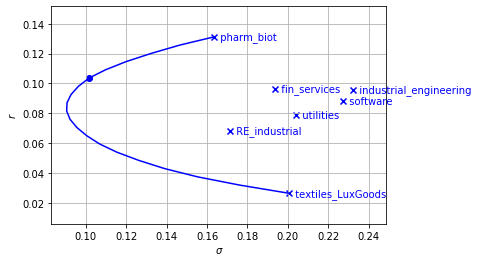

In [17]:
# Mean-variance Optimization (based on equilibrium returns)
optimize_and_display('Optimization based on Equilibrium returns with adjusted views(Neutral)', names, Pi_1+rf, C, rf, color='blue')
show()

Optimization based on Equilibrium returns with adjusted views(Best Case)
Name                      Weight Return    Dev    Correlations
textiles_LuxGoods           5.8%   6.6%  20.1%    1.000 
pharm_biot                 40.2%  15.1%  16.4%    0.061 1.000 
fin_services                0.0%   9.6%  19.3%    0.126 0.341 1.000 
industrial_engineering     11.7%  13.1%  23.2%    0.113 0.277 0.734 1.000 
utilities                   5.5%   8.9%  20.4%    0.082 0.013 -0.022 0.001 1.000 
software                   18.2%  14.3%  22.7%    0.075 0.045 -0.008 -0.001 0.351 1.000 
RE_industrial              18.6%   7.8%  17.1%    0.015 -0.021 -0.041 -0.052 0.159 0.059 1.000 


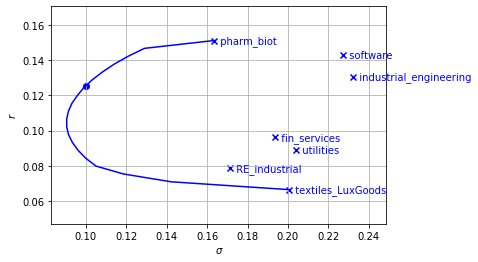

In [18]:
# Mean-variance Optimization (based on equilibrium returns)
optimize_and_display('Optimization based on Equilibrium returns with adjusted views(Best Case)', names, Pi_3+rf, C, rf, color='blue')
show()

Optimization based on Equilibrium returns with adjusted views(Worst Case)
Name                      Weight Return    Dev    Correlations
textiles_LuxGoods           0.0%   0.1%  20.1%    1.000 
pharm_biot                 49.3%  11.6%  16.4%    0.061 1.000 
fin_services               16.0%   9.6%  19.3%    0.126 0.341 1.000 
industrial_engineering      3.9%   9.6%  23.2%    0.113 0.277 0.734 1.000 
utilities                  11.2%   5.4%  20.4%    0.082 0.013 -0.022 0.001 1.000 
software                    0.0%   3.3%  22.7%    0.075 0.045 -0.008 -0.001 0.351 1.000 
RE_industrial              19.6%   5.3%  17.1%    0.015 -0.021 -0.041 -0.052 0.159 0.059 1.000 


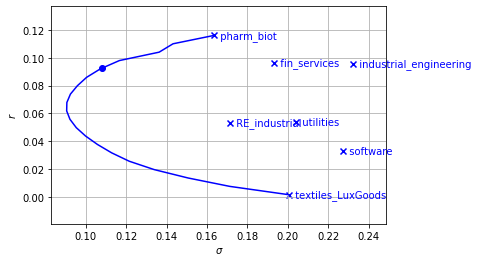

In [19]:
# Mean-variance Optimization (based on equilibrium returns)
optimize_and_display('Optimization based on Equilibrium returns with adjusted views(Worst Case)', names, Pi_2+rf, C, rf, color='blue')
show()